In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

from qiskit import QuantumCircuit, execute, Aer
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

In [2]:
def U_B(beta, n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    for q in range(n_qubits):
        qc.rx(beta, q)
    
    gate = qc.to_gate()
    gate.name = "U_B"
    
    return gate

In [592]:
def U_C(gamma, edges, n_qubits):
    qc = QuantumCircuit(n_qubits)
    e_w_sum = np.sum(edges[:, 2])
    
    for edge in edges:
        t_wire = int(edge[0])
        c_wire = int(edge[1])
        
        qc.cnot(c_wire, t_wire)
        qc.rz(gamma*(edge[2]/e_w_sum), t_wire)
#         qc.rz(gamma*(edge[2]/(e_w_sum))+gamma, t_wire)
#         qc.rz(gamma, t_wire)
        qc.cnot(c_wire, t_wire)
    
    gate = qc.to_gate()
    gate.name = "U_C"
    
    return gate

In [593]:
def QAOA_circuit(parameters, edges, n_qubits):
    qc = QuantumCircuit(n_qubits, n_qubits)
    
#     prepare eigenstate (ground state of mixture Hamiltonian)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    
    qc.barrier()
    
    for p in parameters:
        qc.append(U_C(p[0], edges, n_qubits), range(n_qubits))
        qc.barrier()
        qc.append(U_B(p[1], n_qubits), range(n_qubits))
        qc.barrier()
        
    qc.measure(range(n_qubits), range(n_qubits))
    return qc
    

In [594]:
def most_likely(results):
    max_value = -1
    max_key = ''
    for key, value in zip(results.get_counts().keys(), results.get_counts().values()):
        if value > max_value:
            max_key = key
            max_value = value
    
    return max_key[::-1]

In [595]:
# def cost_function(results, edges):
#     cost = 0
#     for key, value in zip(results.get_counts().keys(), results.get_counts().values()):
#         key = key[::-1]
#         for edge in edges:
#             cost += value * (1 - (int(key[edge[0]]) + int(key[edge[1]])) % 2)
            
#     cost /= shots
#     return cost


def cost_function(results, edges):
    cost = 0
    for key, value in zip(results.get_counts().keys(), results.get_counts().values()):
        k = key[::-1]
        for edge in edges:
            cost += value * edge[2] * (1 - (int(k[int(edge[0])]) + int(k[int(edge[1])])) % 2)
            
#     cost /= shots * np.sum(edges[:, 2])
    cost /= shots
    return cost

In [596]:
# def generate_new_sets(best_set, set_num, deviation):
#     new_set = [best_set]
    
#     for i in range(1, set_num-1, 2):
#         rand_mask = np.random.rand(len(best_set), len(best_set[0]))
#         new_set.append(best_set+rand_mask*deviation*i*2/set_num)
#         new_set.append(best_set-rand_mask*deviation*i*2/set_num)
    
#     return np.array(new_set)

def generate_new_sets(best_set, set_num, deviation):
    new_set = []
    
    for i in range(0, set_num-1, 2):
        rand_mask = np.random.rand(len(best_set), len(best_set[0]))
        new_set.append(best_set+rand_mask*deviation*i/set_num)
        new_set.append(best_set-rand_mask*deviation*i/set_num)
    
    return np.array(new_set)

In [597]:
def max_cut(bin_str, edges):
    cut = 0
    for edge in edges:
        cut += edge[2] * ((int(bin_str[int(edge[0])]) + int(bin_str[int(edge[1])])) % 2)
            
    return cut

In [598]:
def plot_graph(edges, bin_str=""):
    G = nx.Graph()
    
    for edge in edges:
        G.add_edge(int(edge[0]), int(edge[1]), weight=edge[2])
    
    pos = nx.spring_layout(G, seed=1)
    plt.figure(figsize=(10,10))
    
    colop_map = "yellow"
    if len(bin_str) > 0:
        colop_map = []
        for i in range(len(bin_str)):
            if bin_str[i] == "1":
                colop_map.append("lime")
            else:
                colop_map.append("violet")
                
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=colop_map)
    nx.draw_networkx_edges(G, pos, width=1)

    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [599]:
# edges = np.array([[0, 1, 1.0], [0, 2, 1.0], [0, 5, 1.0], [1, 2, 1.0], 
#                   [2, 3, 1.0], [2, 4, 1.0], [4, 5, 1.0], [5, 6, 1.0], 
#                   [0, 7, 1.0], [6, 8, 1.0], [8, 7, 1.0], [6, 7, 1.0]])

# edges = np.array([[0, 1, 10.0], [0, 2, 1.0], [0, 5, 5.0], [1, 2, 2.0], 
#                   [2, 3, 1.0], [2, 4, 1.0], [4, 5, 15.0], [5, 6, 1.0], 
#                   [0, 7, 1.0], [6, 8, 2.0], [8, 7, 2.0], [6, 7, 10.0]])

# edges = np.array([[0, 1, 0.51], [0, 4, 0.63], [0, 5, 0.91], [0, 6, 0.19], 
#                   [1, 2, 0.82], [1, 3, 0.53], [1, 4, 0.61], [1, 7, 0.1], 
#                   [2, 3, 0.2], [3, 4, 0.84], [4, 5, 0.41], [6, 7, 0.76], 
#                   [6, 9, 0.31], [6, 10, 0.23], [6, 11, 0.08], [7, 8, 0.14],
#                   [7, 9, 0.78], [8, 9, 0.23], [9, 10, 0.52], [10, 11, 0.79]])

edges = np.array([[0, 1, 0.51], [1, 2, 0.82], [1, 3, 0.53], [0, 4, 0.63], 
                  [0, 5, 0.91], [0, 6, 0.19], [1, 4, 0.61], [1, 7, 0.1], 
                  [2, 3, 0.2], [3, 4, 0.84], [4, 5, 0.41], [6, 7, 0.76], 
                  [7, 8, 0.14], [6, 9, 0.31], [6, 10, 0.23], [6, 11, 0.08], 
                  [7, 9, 0.78], [8, 9, 0.23], [9, 10, 0.52], [10, 11, 0.79]])

# edges = np.array([[0, 1, 0.51], [1, 2, 0.82], [1, 3, 0.53], [0, 4, 0.63], 
#                   [0, 5, 0.91], [0, 6, 0.19], [1, 4, 0.61], [1, 7, 0.1], 
#                   [2, 3, 0.2], [3, 4, 0.84], [4, 5, 0.41], [6, 7, 0.76], 
#                   [7, 8, 0.14], [6, 9, 0.11], [6, 10, 0.23], [6, 11, 0.08], 
#                   [7, 9, 10.98], [8, 9, 0.23], [9, 10, 0.52], [10, 11, 0.79]])

# edges = np.array([[0, 1, 1.0], [0, 2, 1.0], [0, 3, 1.0], [0, 4, 1.0], [0, 5, 1.0]])
# edges = np.array([[0, 1, 3.0], [1, 2, 3.0], [2, 3, 4.0], [0, 3, 1.0], [0, 2, 10.0], [1, 3, 2.0]])

# edges = np.array([[0, 1, 1.0], [1, 2, 1.0], [2, 3, 1.0], [0, 3, 1.0]])

nodes = 12
n_qubits = nodes

backend = Aer.get_backend('qasm_simulator')
shots = 1024

def evo_training(circuit, layers=2, set_num=10, epochs=1, deviation=0.1):
    set_p = np.random.rand(set_num, layers, 2) * 0.0001
    best_params = None
    best_cost = np.sum(edges[:, 2])
    same_cost_counter = 0
    
    for epoch in range(epochs):
        for parameters in set_p:
            circuit = QAOA_circuit(parameters, edges, n_qubits)
            results = execute(circuit, backend=backend, shots=shots).result()

            curr_cost = cost_function(results, edges)
            if curr_cost < best_cost:
                best_params = parameters
                best_cost = curr_cost
            elif curr_cost == best_cost:
                same_cost_counter += 1
            
        print("Epoch : ", epoch, "\tBest Cost : ", best_cost)
            
        if same_cost_counter == 5:
            set_p = generate_new_sets(best_params, set_num, deviation*10000)
            same_cost_counter = 0
        else:
            set_p = generate_new_sets(best_params, set_num, deviation)

    return best_params
        

In [649]:
best_params = evo_training(circuit, layers=15, set_num=50, epochs=20, deviation=0.9)
# best_params = evo_training(circuit, layers=6, set_num=10, epochs=100, deviation=0.9)

Epoch :  0 	Best Cost :  4.691347656250039
Epoch :  1 	Best Cost :  4.178505859375068
Epoch :  2 	Best Cost :  4.178505859375068
Epoch :  3 	Best Cost :  4.020927734375074
Epoch :  4 	Best Cost :  3.8966699218750653
Epoch :  5 	Best Cost :  3.8966699218750653
Epoch :  6 	Best Cost :  3.8725781250000675
Epoch :  7 	Best Cost :  3.851982421875051
Epoch :  8 	Best Cost :  3.851982421875051
Epoch :  9 	Best Cost :  3.851982421875051
Epoch :  10 	Best Cost :  3.851982421875051
Epoch :  11 	Best Cost :  3.8339941406250606
Epoch :  12 	Best Cost :  3.8339941406250606
Epoch :  13 	Best Cost :  3.8339941406250606
Epoch :  14 	Best Cost :  3.8339941406250606
Epoch :  15 	Best Cost :  3.8339941406250606
Epoch :  16 	Best Cost :  3.8339941406250606
Epoch :  17 	Best Cost :  3.8339941406250606
Epoch :  18 	Best Cost :  3.8339941406250606
Epoch :  19 	Best Cost :  3.8339941406250606


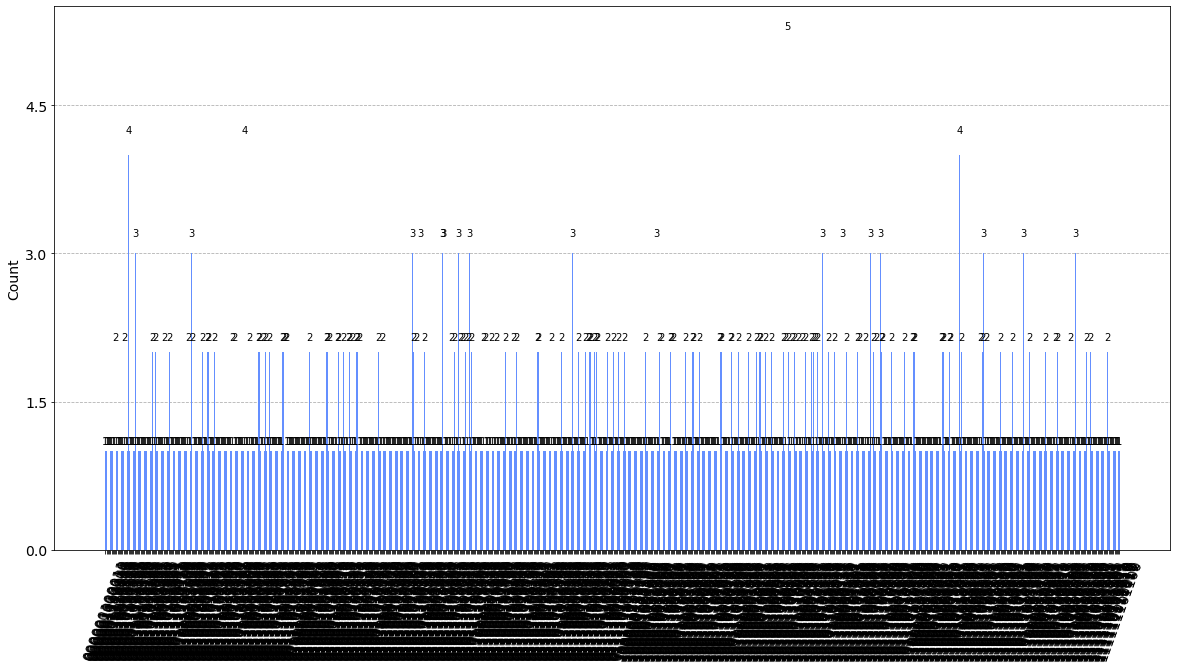

In [674]:
circuit = QAOA_circuit(best_params, edges, n_qubits)
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer,  figsize=(20, 10))

In [675]:
print("Ground state : ", most_likely(results))
print("Max cut : ", max_cut(most_likely(results), edges))

Ground state :  010101100101
Max cut :  7.900000000000001


In [671]:
print("Max cut : ", max_cut("010101100101", edges))

Max cut :  7.900000000000001


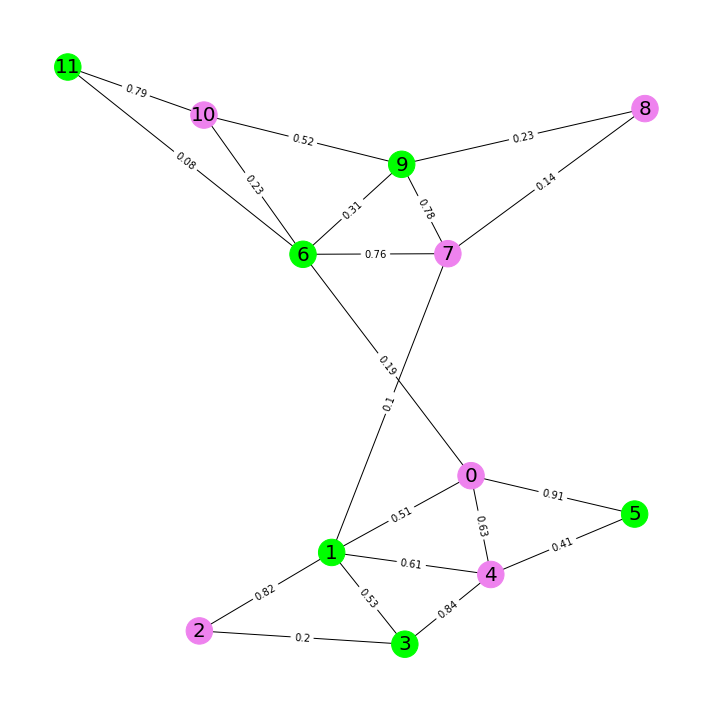

In [677]:
plot_graph(edges, most_likely(results))
# plot_graph(edges, "010101100101")

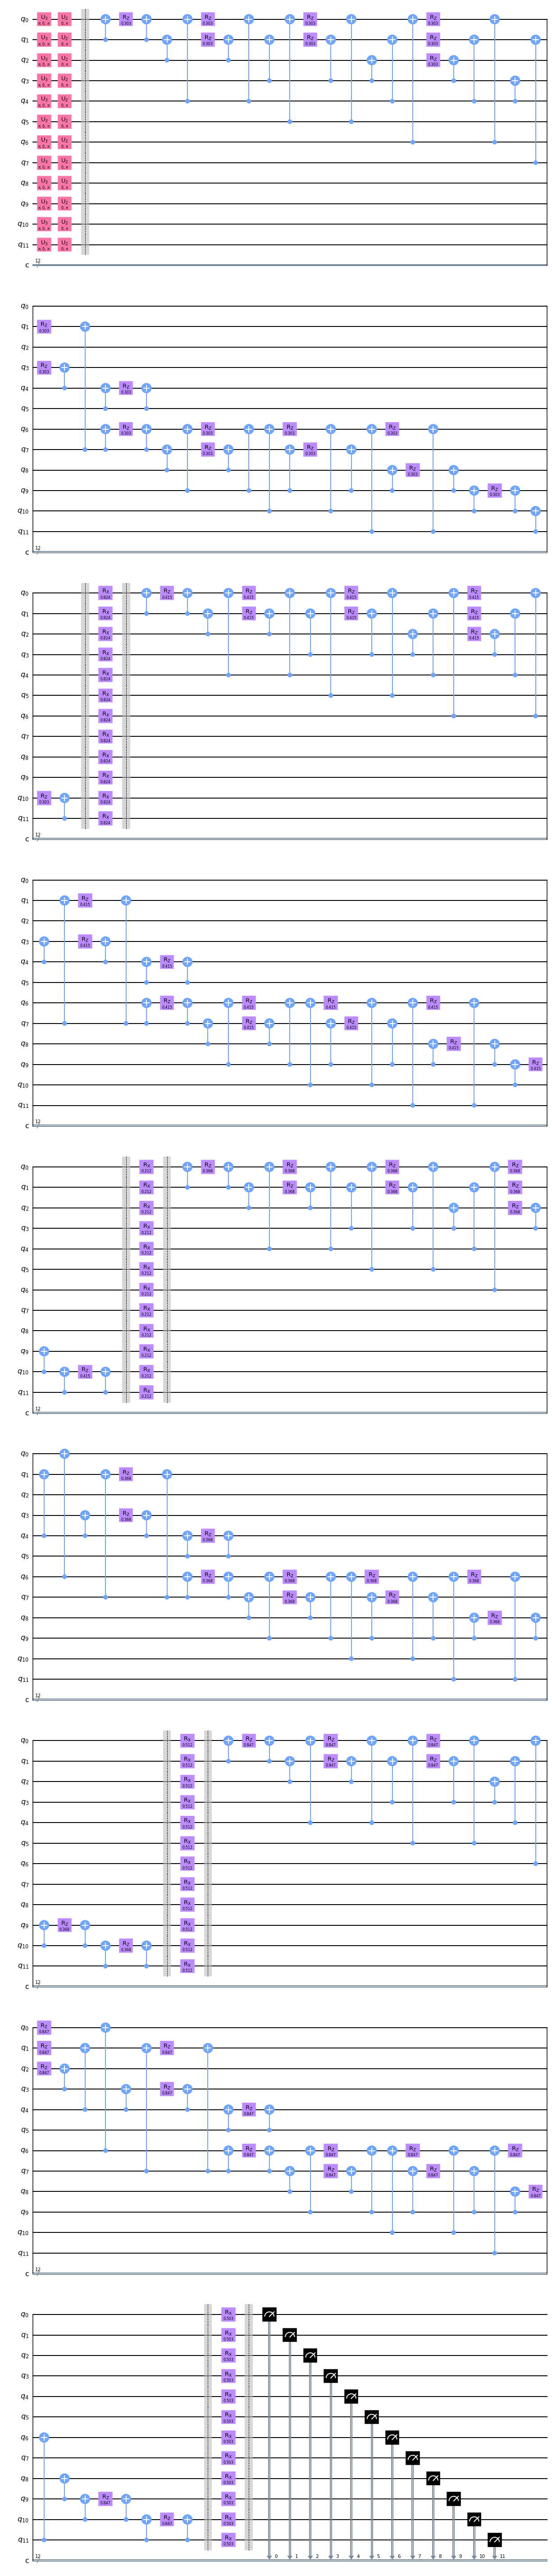

In [213]:
circuit.decompose(reps=1).draw('mpl')